In [1]:
# ------------------------------------------------------------------------
# Task 3: Forecast Analysis (use trained models to produce forecasts)
# ------------------------------------------------------------------------

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import pmdarima as pm
import pickle

In [4]:
# Paths (edit if different)
BASE = r"D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization"
DATA_PATH = os.path.join(BASE, "data", "processed", "all_assets_processed.csv")
LSTM_MODEL_PATH = os.path.join(BASE, "outputs", "results", "lstm_model.keras")
ARIMA_MODEL_PATH = os.path.join(BASE, "outputs", "results", "arima_model.pkl")  # optional saved arima
OUT_PLOTS = os.path.join(BASE, "outputs", "plots")
OUT_RESULTS = os.path.join(BASE, "outputs", "results")
os.makedirs(OUT_PLOTS, exist_ok=True)
os.makedirs(OUT_RESULTS, exist_ok=True)

In [5]:
# -------------------------
# Load historical data
# -------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["Date"], index_col="Date").sort_index()
# ensure business day frequency (helps ARIMA)
df = df.asfreq("B").ffill().bfill()

tsla = df["TSLA"].copy()
print("Loaded TSLA series:", tsla.index.min(), "->", tsla.index.max())

Loaded TSLA series: 2015-07-01 00:00:00 -> 2025-07-30 00:00:00


In [6]:
# -------------------------
# Load scaler and model for LSTM
# -------------------------
# We'll create a MinMaxScaler fit on historical TSLA (this should match training)
scaler = MinMaxScaler(feature_range=(0, 1))
tsla_values = tsla.values.reshape(-1, 1)
scaler.fit(tsla_values)  # fit on whole history for forecasting future

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [7]:
# Load LSTM model
try:
    lstm = load_model(LSTM_MODEL_PATH)
    print("Loaded LSTM model from", LSTM_MODEL_PATH)
except Exception as e:
    print("Failed to load LSTM model:", e)
    lstm = None

Loaded LSTM model from D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\outputs\results\lstm_model.keras


In [8]:
# -------------------------
# Forecast settings
# -------------------------
forecast_horizon_months = 6
trading_days_per_month = 21
forecast_steps = forecast_horizon_months * trading_days_per_month
look_back = 60  # should match the look_back used in training

In [11]:
# -------------------------
# LSTM: iterative multi-step forecasting
# -------------------------
if lstm is not None:
    # scale entire history and get last sequence
    scaled = scaler.transform(tsla_values)
    last_seq = scaled[-look_back:].reshape(look_back, 1).copy()
    future_scaled = []
    cur_seq = last_seq.copy()
    for i in range(forecast_steps):
        pred_scaled = lstm.predict(cur_seq.reshape(1, look_back, 1), verbose=0)[0, 0]
        future_scaled.append(pred_scaled)
        # slide window
        cur_seq = np.append(cur_seq[1:], [[pred_scaled]], axis=0)

    future_prices = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()

    # Build future dates
    last_date = tsla.index.max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq="B")
    tsla_lstm_forecast = pd.Series(future_prices, index=future_dates, name="LSTM_Forecast")
    tsla_lstm_forecast.to_csv(os.path.join(OUT_RESULTS, "tsla_lstm_future_forecast.csv"), header=True)
    print("Saved LSTM forecast to", os.path.join(OUT_RESULTS, "tsla_lstm_future_forecast.csv"))
else:
    tsla_lstm_forecast = None
    print("Skipping LSTM forecasting (model not available).")

Saved LSTM forecast to D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\outputs\results\tsla_lstm_future_forecast.csv


In [12]:
# -------------------------
# Estimate LSTM confidence intervals (simple empirical residual method)
# -------------------------
# We'll compute in-sample residual std from sequences within historical period.
# Create sequences across the historical series and compare model predictions to actuals
lstm_ci_lower = lstm_ci_upper = None
if lstm is not None:
    # Build sequences across historical data up to last available day (no future)
    scaled_full = scaler.transform(tsla_values)
    X_hist = []
    y_hist = []
    for i in range(look_back, len(scaled_full)):
        X_hist.append(scaled_full[i - look_back:i, 0])
        y_hist.append(scaled_full[i, 0])
    X_hist = np.array(X_hist).reshape(-1, look_back, 1)
    y_hist = np.array(y_hist)

    # In-sample predictions (scaled)
    pred_hist_scaled = lstm.predict(X_hist, verbose=0).flatten()
    pred_hist = scaler.inverse_transform(pred_hist_scaled.reshape(-1, 1)).flatten()
    y_hist_actual = scaler.inverse_transform(y_hist.reshape(-1, 1)).flatten()

    residuals = y_hist_actual - pred_hist
    resid_std = np.std(residuals, ddof=1)
    z = 1.96  # 95% approx
    # apply to forecast
    if tsla_lstm_forecast is not None:
        lstm_ci_lower = tsla_lstm_forecast - z * resid_std
        lstm_ci_upper = tsla_lstm_forecast + z * resid_std
        # save CI as CSV
        pd.DataFrame({
            "LSTM_Forecast": tsla_lstm_forecast,
            "LSTM_CI_Lower": lstm_ci_lower,
            "LSTM_CI_Upper": lstm_ci_upper
        }).to_csv(os.path.join(OUT_RESULTS, "tsla_lstm_forecast_with_ci.csv"))
        print("Saved LSTM forecast with CI to", os.path.join(OUT_RESULTS, "tsla_lstm_forecast_with_ci.csv"))

Saved LSTM forecast with CI to D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\outputs\results\tsla_lstm_forecast_with_ci.csv


In [14]:
arima_forecast = None
arima_conf_int = None

try:
    # Try to load saved model using pickle
    if os.path.exists(ARIMA_MODEL_PATH):
        print("Loading saved ARIMA model...")
        with open(ARIMA_MODEL_PATH, 'rb') as f:
            arima_model = pickle.load(f)
    else:
        # Fit auto_arima if no saved model exists
        print("No saved ARIMA model found. Fitting auto_arima on historical TSLA (this may take a little)...")
        arima_model = pm.auto_arima(
            tsla, 
            start_p=1, start_q=1,
            max_p=5, max_q=5, 
            seasonal=False,
            m=1, 
            d=None, 
            stepwise=True, 
            trace=True,  # Changed to True for better visibility
            error_action='ignore', 
            suppress_warnings=True,
            n_jobs=-1  # Enable parallel processing
        )
        
        # Save model using pickle
        with open(ARIMA_MODEL_PATH, 'wb') as f:
            pickle.dump(arima_model, f)
        print(f"Saved ARIMA model to {ARIMA_MODEL_PATH}")

    # Generate forecast with confidence intervals
    arima_pred, arima_conf = arima_model.predict(
        n_periods=forecast_steps, 
        return_conf_int=True, 
        alpha=0.05
    )
    
    # Create datetime index for future dates (business days)
    last_date = tsla.index.max()
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1), 
        periods=forecast_steps, 
        freq="B"
    )
    
    # Create forecast Series and confidence interval DataFrame
    arima_forecast = pd.Series(
        arima_pred, 
        index=future_dates, 
        name="ARIMA_Forecast"
    )
    
    arima_conf_int = pd.DataFrame(
        arima_conf, 
        index=future_dates, 
        columns=["lower", "upper"]
    )
    
    # Save results
    arima_forecast.to_csv(
        os.path.join(OUT_RESULTS, "tsla_arima_future_forecast.csv"),
        header=True
    )
    arima_conf_int.to_csv(
        os.path.join(OUT_RESULTS, "tsla_arima_conf_int.csv")
    )
    print("Successfully saved ARIMA forecast and confidence intervals.")
    
except Exception as e:
    print(f"ARIMA forecasting failed: {str(e)}")
    arima_forecast = None
    arima_conf_int = None

Loading saved ARIMA model...
Successfully saved ARIMA forecast and confidence intervals.


d:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


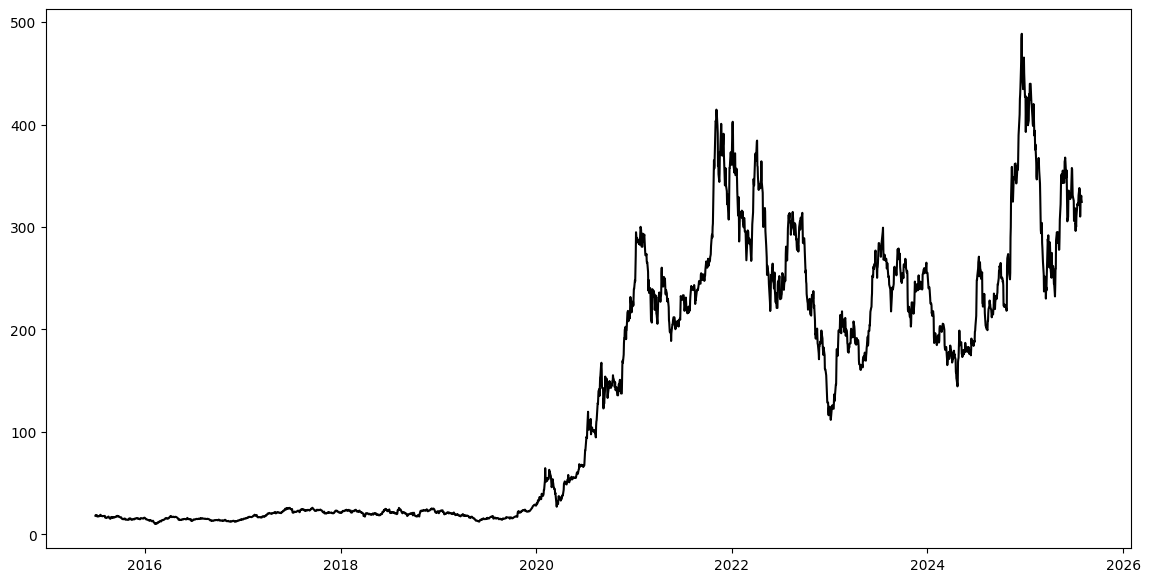

In [15]:
# -------------------------
# Combine & Plot: Historical + Forecasts
# -------------------------
plt.figure(figsize=(14, 7))
plt.plot(tsla.index, tsla.values, label="Historical TSLA", color="black")

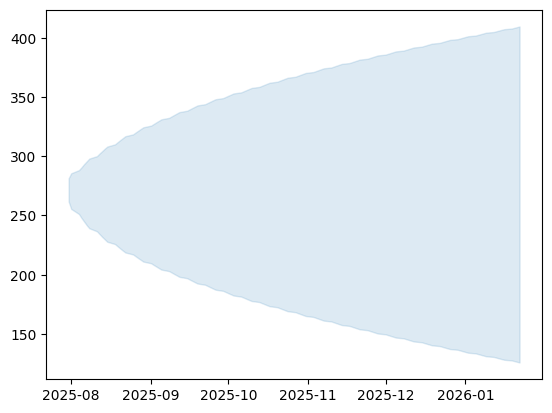

In [16]:
# Plot ARIMA forecast & CI
if arima_forecast is not None:
    plt.plot(arima_forecast.index, arima_forecast.values, label="ARIMA Forecast", color="tab:blue")
    plt.fill_between(arima_conf_int.index, arima_conf_int["lower"], arima_conf_int["upper"], color="tab:blue", alpha=0.15)


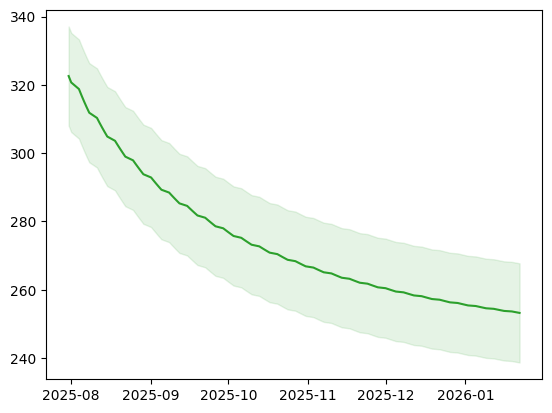

In [17]:
# Plot LSTM forecast & CI
if tsla_lstm_forecast is not None:
    plt.plot(tsla_lstm_forecast.index, tsla_lstm_forecast.values, label="LSTM Forecast", color="tab:green")
    if (lstm_ci_lower is not None) and (lstm_ci_upper is not None):
        plt.fill_between(lstm_ci_lower.index, lstm_ci_lower.values, lstm_ci_upper.values, color="tab:green", alpha=0.12)


C:\Users\ayish\AppData\Local\Temp\ipykernel_16624\1542464506.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


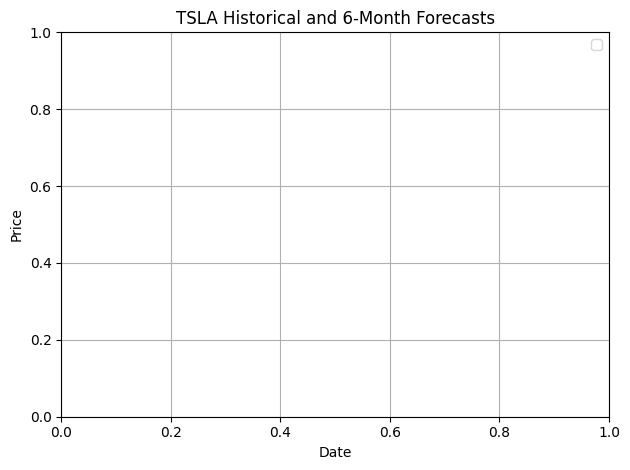

In [18]:
plt.title(f"TSLA Historical and {forecast_horizon_months}-Month Forecasts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_PLOTS, "tsla_forecasts_comparison.png"))
plt.show()

In [19]:
# -------------------------
# Simple Forecast Interpretation & Summary (text)
# -------------------------
summary_lines = []
if arima_forecast is not None:
    arima_trend_pct = ((arima_forecast.mean() - tsla.iloc[-1]) / tsla.iloc[-1]) * 100
    summary_lines.append(f"ARIMA: mean forecast over next {forecast_steps} trading days = {arima_forecast.mean():.2f} "
                         f"({arima_trend_pct:.2f}% vs last price {tsla.iloc[-1]:.2f})")

if tsla_lstm_forecast is not None:
    lstm_trend_pct = ((tsla_lstm_forecast.mean() - tsla.iloc[-1]) / tsla.iloc[-1]) * 100
    summary_lines.append(f"LSTM: mean forecast over next {forecast_steps} trading days = {tsla_lstm_forecast.mean():.2f} "
                         f"({lstm_trend_pct:.2f}% vs last price {tsla.iloc[-1]:.2f})")

summary_text = "\n".join(summary_lines)
print("\nForecast Summary:")
print(summary_text)



Forecast Summary:
ARIMA: mean forecast over next 126 trading days = nan (nan% vs last price 324.45)
LSTM: mean forecast over next 126 trading days = 273.96 (-15.56% vs last price 324.45)


In [20]:
summary_text = "\n".join(summary_lines)
print("\nForecast Summary:")
print(summary_text)

# Save summary text
with open(os.path.join(OUT_RESULTS, "forecast_summary.txt"), "w") as f:
    f.write("Forecast Summary\n")
    f.write("================\n")
    f.write(summary_text + "\n")


Forecast Summary:
ARIMA: mean forecast over next 126 trading days = nan (nan% vs last price 324.45)
LSTM: mean forecast over next 126 trading days = 273.96 (-15.56% vs last price 324.45)


In [22]:
# Save summary text
with open(os.path.join(OUT_RESULTS, "forecast_summary.txt"), "w") as f:
    f.write("Forecast Summary\n")
    f.write("================\n")
    f.write(summary_text + "\n")

# -------------------------
# Save combined forecasts for Task 4 (portfolio optimization)
# -------------------------
combined_df = pd.DataFrame(index=future_dates)
if arima_forecast is not None:
    combined_df["ARIMA_TSLA"] = arima_forecast
if tsla_lstm_forecast is not None:
    combined_df["LSTM_TSLA"] = tsla_lstm_forecast

combined_df.to_csv(os.path.join(OUT_RESULTS, "tsla_combined_future_forecasts.csv"))
print("Saved combined forecasts for downstream tasks:", os.path.join(OUT_RESULTS, "tsla_combined_future_forecasts.csv"))


Saved combined forecasts for downstream tasks: D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\outputs\results\tsla_combined_future_forecasts.csv
